In [1]:
from analysis import (
    read_public_scores,
    plot_set_contributions,
    convert,
    randomly_permute,
    sensitivity_analysis,
    plot_quality_coverage,
    read_public_and_private_scores,
    compute_agreement_between_practitioners,
    kappa_,
    get_cumulative_scales,
    kappa_large_gap
)

from prioritization_framework import get_n_practices_greedy, get_n_practices_brute_force
import pandas as pd
import numpy as np
from functools import partial
from scipy import stats

# Annotator Agreement

We compute the agreement of the 13 annotators in the public and private set of practices.

In [2]:
internal_set = read_public_and_private_scores(csv_path='data/internal_set/scores_annotators.tsv', normalise=True)

## Plain agreement

In [3]:
plain_agreement = lambda x, y: (x == y).mean()
plain = compute_agreement_between_practitioners(internal_set, "Annotator_", plain_agreement)
plain_statistics = pd.Series(plain.values.flatten()).dropna().describe()

print(f'The average plain agreement is {round(plain_statistics["mean"] * 100,2)}%')

print(f'The standard deviation of the plain agreement is {round(plain_statistics["std"]*100,3)}%')

The average plain agreement is 73.56%
The standard deviation of the plain agreement is 1.38%


## Practical Agreement

In [4]:
practical_agreement_normalized = lambda x, y: ((x - y).abs() < 0.5).mean()
practical = compute_agreement_between_practitioners(internal_set, "Annotator_", practical_agreement_normalized)
practical_statistics = pd.Series(practical.values.flatten()).dropna().describe()


print(f'The average practical agreement is {round(practical_statistics["mean"] * 100, 2)}%')
print(f'The standard deviation of the practical agreement is {round(practical_statistics["std"] * 100,2)}%')

The average practical agreement is 86.38%
The standard deviation of the practical agreement is 1.68%


## Kappa Score

### Kappa score for plain agreement

In [5]:
kappa_plain_agreement = compute_agreement_between_practitioners(internal_set, "Annotator_", kappa_)

kappa_plain_agreement_statistics = pd.Series(kappa_plain_agreement.values.flatten()).dropna().describe()

print(f'The mean kappa of the plain agreement rates is: {round(kappa_plain_agreement_statistics["mean"],2)}')
print(f'The standard deviation of kappa for the plain agreement rates is: {round(kappa_plain_agreement_statistics["std"],3)}')

The mean kappa of the plain agreement rates is: 0.4
The standard deviation of kappa for the plain agreement rates is: 0.043


### Kappa score for practical agreement

In [6]:
kappa_practical_agreement = compute_agreement_between_practitioners(internal_set, "Annotator_", kappa_large_gap)

kappa_practical_agreement_statistics = pd.Series(kappa_practical_agreement.values.flatten()).dropna().describe()

print(f'The mean kappa of the practical agreement rates is: {round(kappa_practical_agreement_statistics["mean"],3)}')
print(f'The standard deviation of kappa for the practical agreement rates is: {round(kappa_practical_agreement_statistics["std"],3)}')

The mean kappa of the practical agreement rates is: 0.689
The standard deviation of kappa for the practical agreement rates is: 0.049


# Analysis of Internal and Open source practice sets

## Plot coverage of quality sub-characteristics

In [7]:
internal_practices = read_public_and_private_scores(csv_path='data/internal_set/scores_annotators.tsv', normalise=False)
internal_practices = internal_practices.rename(columns={
    "quality sub-characteristic": "Subcharacteristics", 
    "Practice": "External Practice Name"
})
internal_practices["Score"] = internal_practices[[col_name for col_name in internal_practices.columns if "Annotator" in col_name]].median(axis=1)


In [8]:
serban_practices_csv = "data/public_sets/Scoring Sheet - Serban.tsv"
rubric_csv = "data/public_sets/Scoring Sheet - Breck.tsv"
microsoft_csv = "data/public_sets/Scoring Sheet - Amershi.tsv"

serban_practices = read_public_scores(serban_practices_csv)
breck_practices = read_public_scores(rubric_csv)
amershi_practices = read_public_scores(microsoft_csv)

assert len(serban_practices) > 0
assert len(breck_practices) > 0
assert len(amershi_practices) > 0

merged_practices = pd.concat([serban_practices, breck_practices, amershi_practices])

practices_map = {
    "Serban et al": serban_practices,
    "Breck et al": breck_practices,
    "Amershi et al": amershi_practices,
    "Internal": internal_practices,
    "ALL": merged_practices
}

for practice_name, scores in practices_map.items():
    scores["Score_Scaled"] = convert(scores["Score"])

merged_series = merged_practices.set_index(['Subcharacteristics', 'External Practice Name'])['Score_Scaled']

points_for_all_practices = {}

for practice_name, scores in practices_map.items():
    points_for_all_practices[practice_name] = (scores
                   .groupby("Subcharacteristics")["Score_Scaled"]
                   .agg([np.sum])
                   .rename(columns={'sum': 'Sum of scores'})
                   .sort_values(by="Sum of scores"))

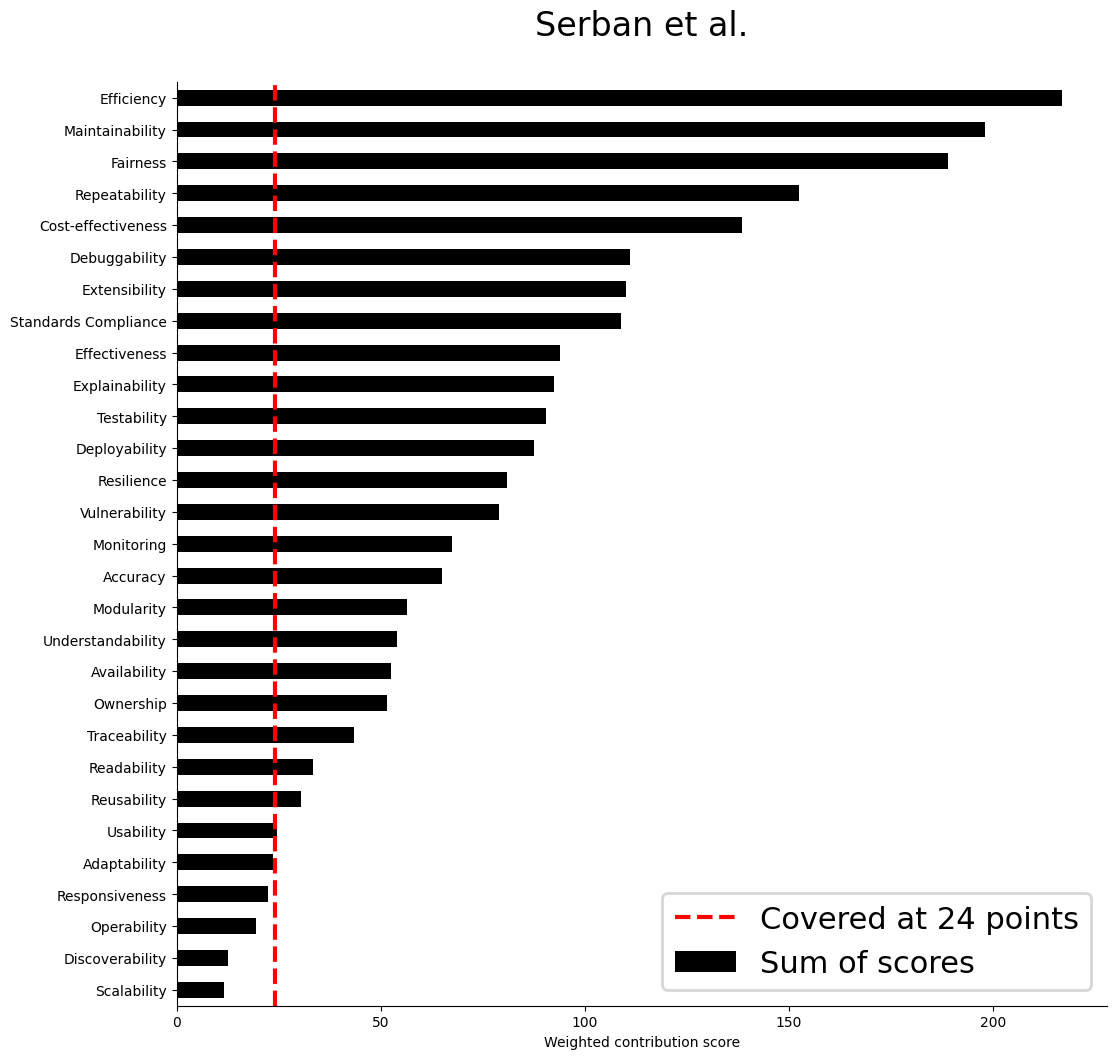

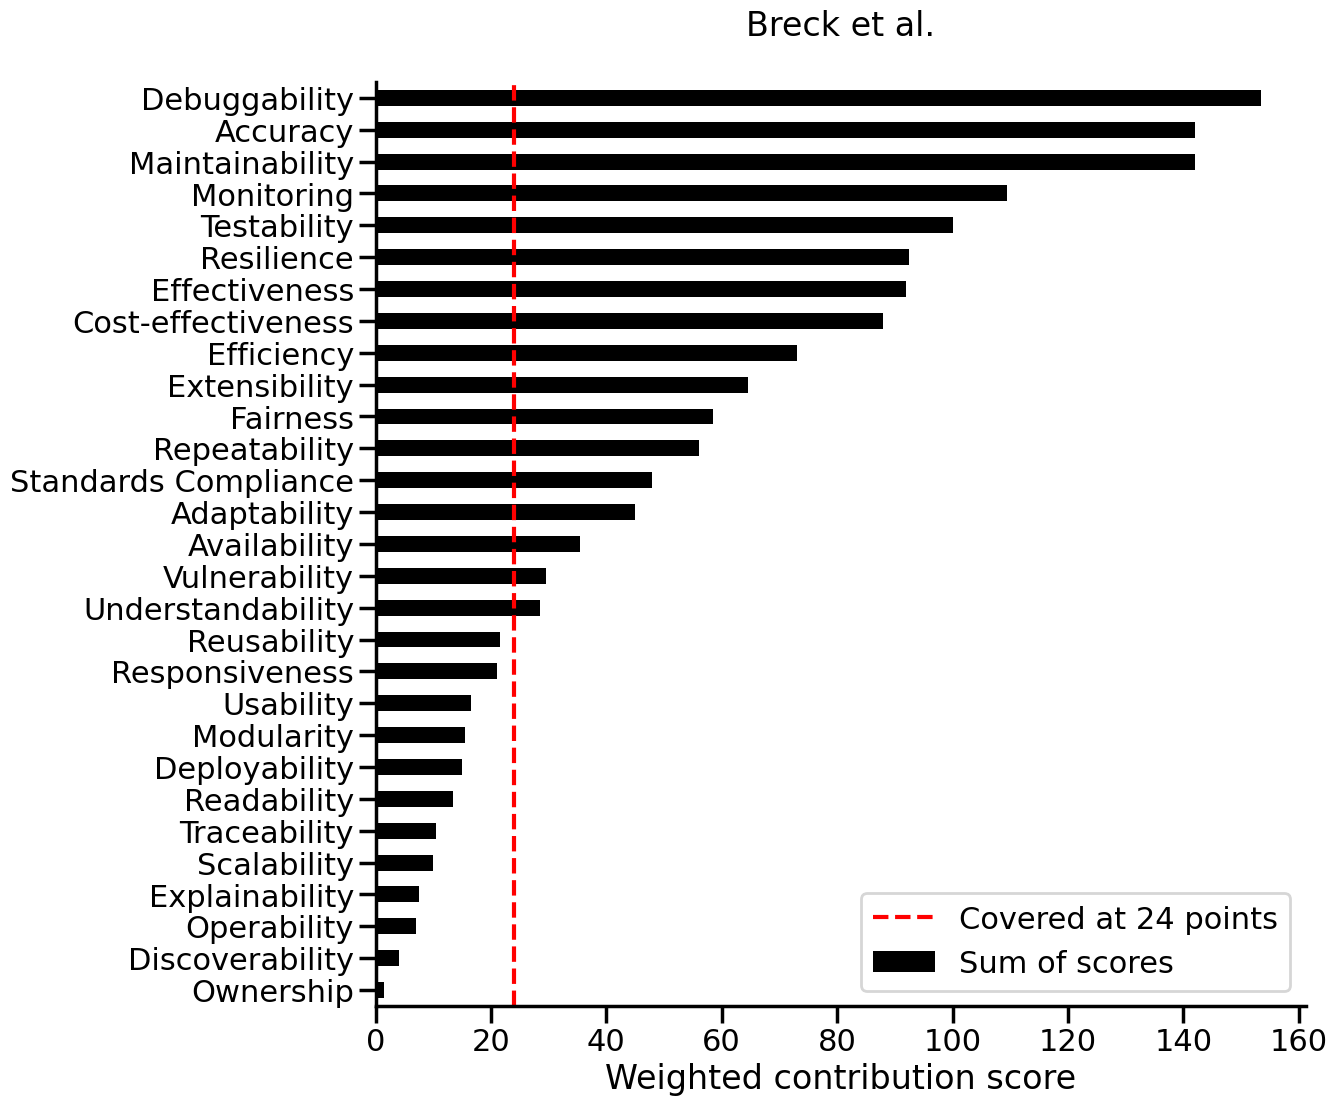

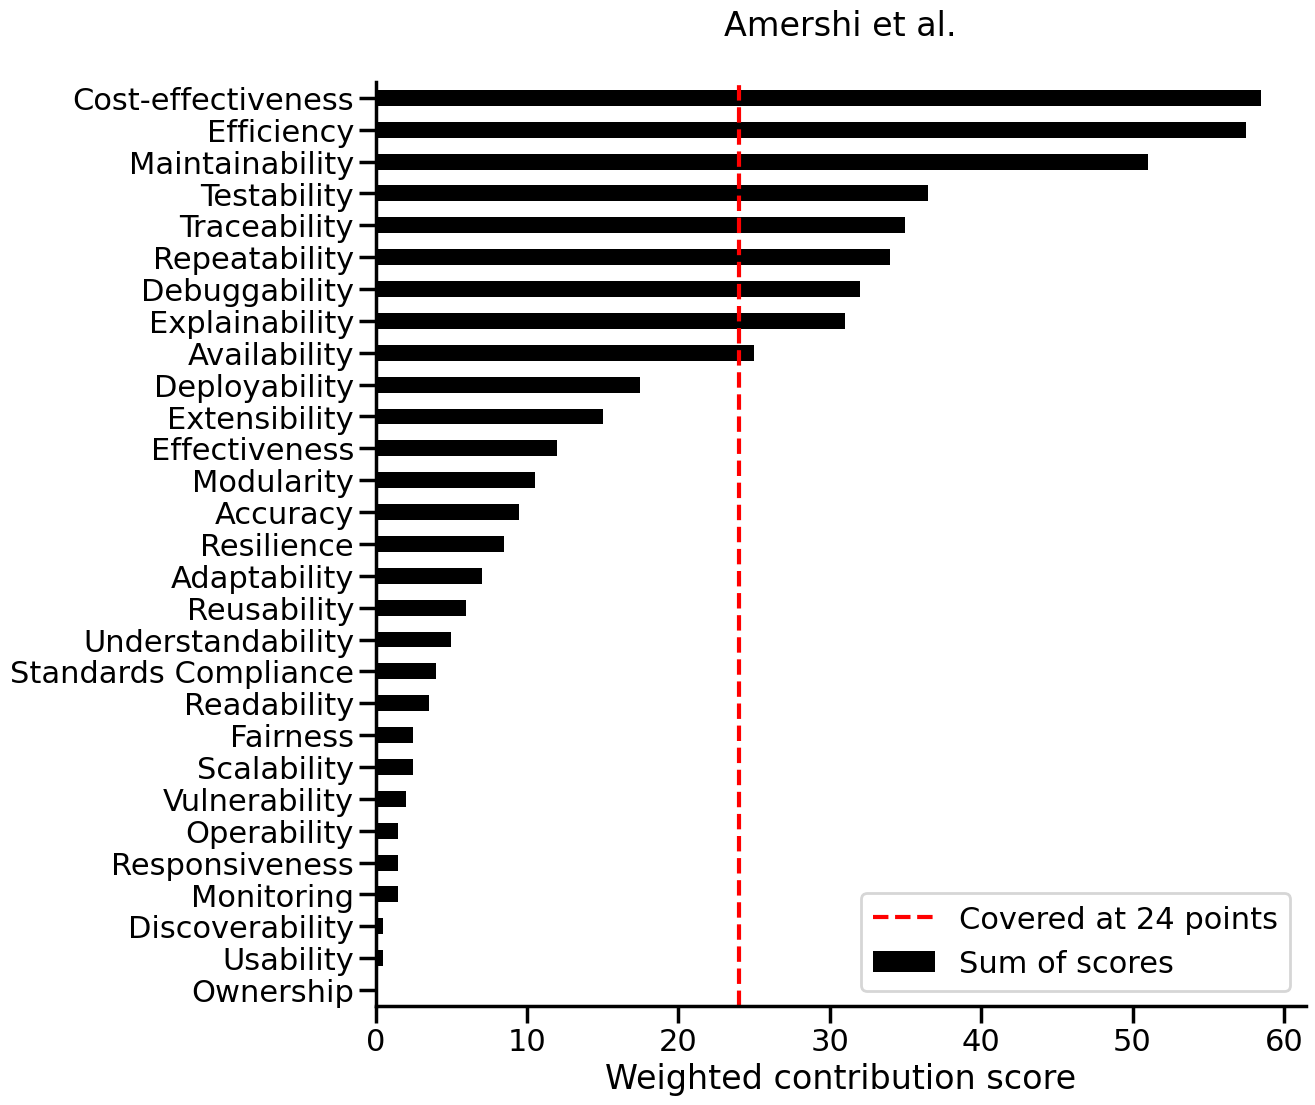

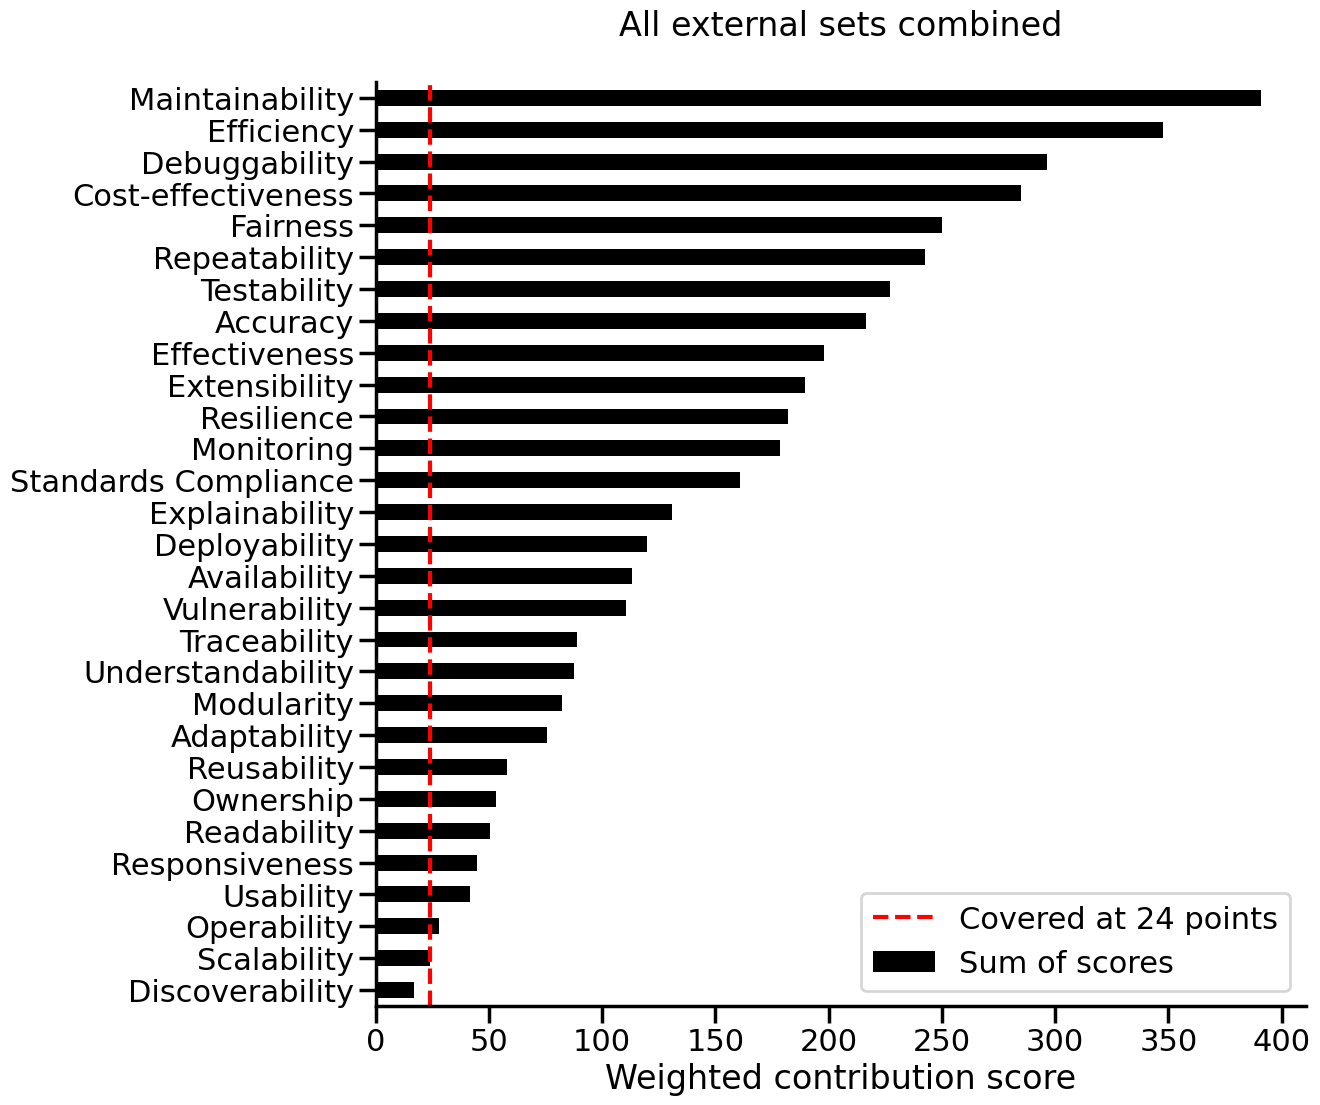

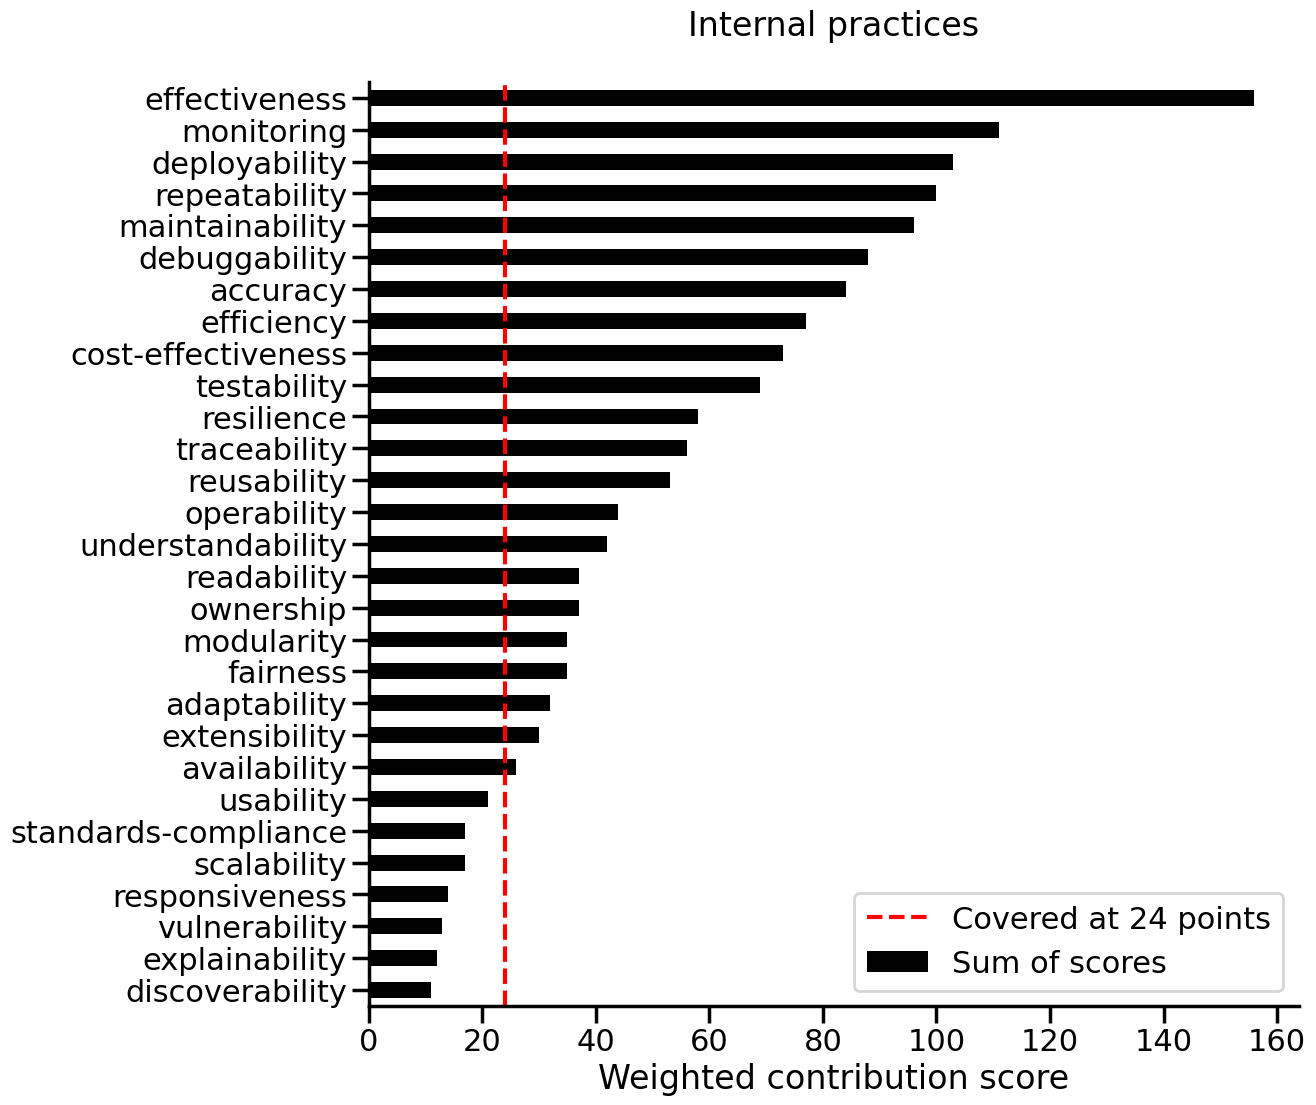

In [9]:
plot_set_contributions(points_for_all_practices=points_for_all_practices,
                       index='Serban et al',
                       title='Serban et al.')

plot_set_contributions(points_for_all_practices=points_for_all_practices,
                       index='Breck et al',
                       title='Breck et al.')

plot_set_contributions(points_for_all_practices=points_for_all_practices,
                       index='Amershi et al',
                       title='Amershi et al.')

plot_set_contributions(points_for_all_practices=points_for_all_practices,
                       index='ALL',
                       title='All external sets combined')

plot_set_contributions(points_for_all_practices=points_for_all_practices,
                       index='Internal',
                       title='Internal practices')

## Score Sensitivity

In [10]:
N=1000
# N = 100

perturbations = {
    "[-1; 1]": partial(randomly_permute, lb=-1, up=2),
    "[-2; 2]": partial(randomly_permute, lb=-2, up=3),
    "[-3; 3]": partial(randomly_permute, lb=-3, up=4)
}

sensitivity_analysis_results = {}

for name, pert_f in perturbations.items():
    sensitivity_analysis_results[name] = sensitivity_analysis(N=N, name=name, permutation_f=pert_f, practices=merged_practices)

for name, results in sensitivity_analysis_results.items():
    print(name, stats.describe(results))

[-1; 1]:   0%|          | 0/1000 [00:00<?, ?it/s]

[-2; 2]:   0%|          | 0/1000 [00:00<?, ?it/s]

[-3; 3]:   0%|          | 0/1000 [00:00<?, ?it/s]

[-1; 1] DescribeResult(nobs=1000, minmax=(0.8970443349753694, 0.9837438423645319), mean=0.9484548220435124, variance=0.0001814734062273289, skewness=-0.408015402668091, kurtosis=0.30404031263164644)
[-2; 2] DescribeResult(nobs=1000, minmax=(0.7923134017244601, 0.9655172413793104), mean=0.9119207427250715, variance=0.000601852887319094, skewness=-0.6537108685804136, kurtosis=0.7741309845932132)
[-3; 3] DescribeResult(nobs=1000, minmax=(0.712403010699912, 0.9530730457807602), mean=0.8599577276228411, variance=0.0015935890824051735, skewness=-0.5326991849444709, kurtosis=0.10813589933934464)


## How many practices are enough?

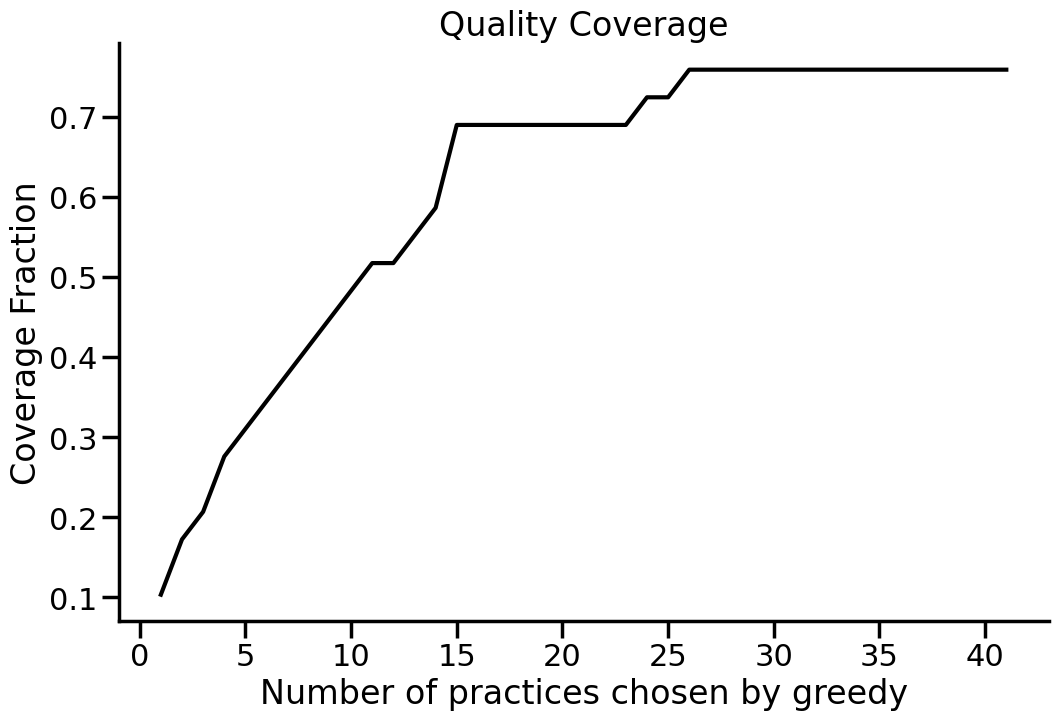

In [11]:
plot_quality_coverage(merged_practices=internal_practices.set_index(['Subcharacteristics', 'External Practice Name'])["Score_Scaled"])

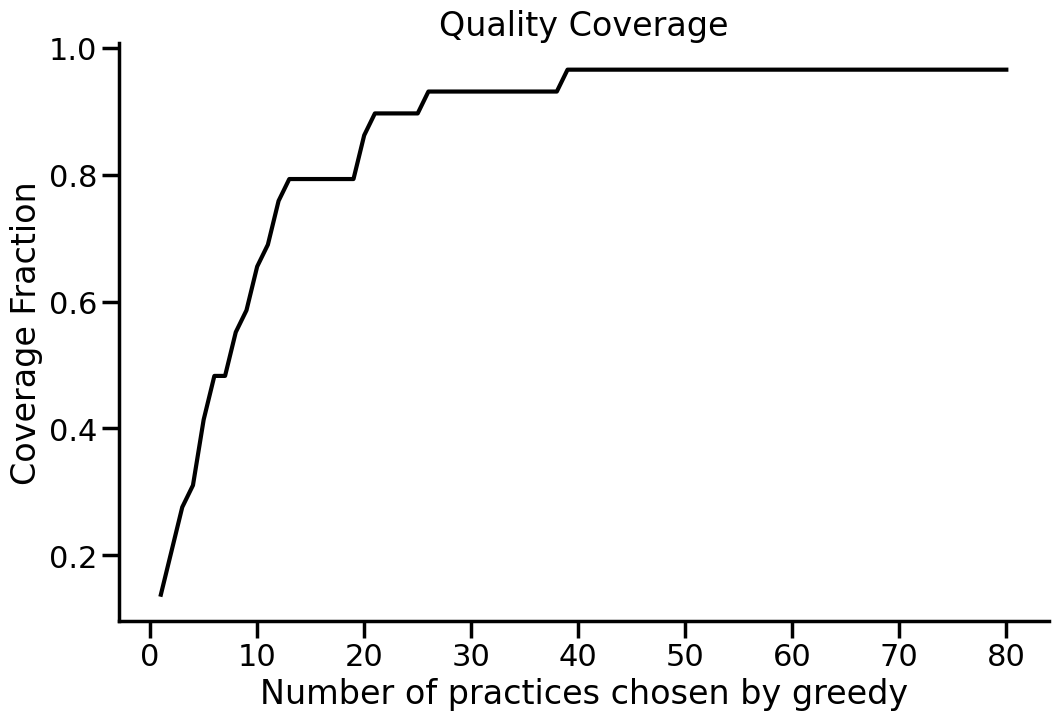

In [12]:
plot_quality_coverage(merged_practices=merged_series)

## Agreement between annotators A and B

### Plain Agreement

In [13]:
compute_agreement_between_practitioners(merged_practices, "Score Annotator", plain_agreement)

,A,B
B,0.634914,NaN
mean,0.634914,0.634914
A,NaN,0.634914


### Practical agreement

In [14]:
practical_agreement = lambda x, y: ((x - y).abs() < 2).mean()

compute_agreement_between_practitioners(merged_practices, "Score Annotator", practical_agreement)

,A,B
B,0.944397,NaN
mean,0.944397,0.944397
A,NaN,0.944397


# Algorithms

In [15]:
internal_series=internal_practices.set_index(['Subcharacteristics', 'External Practice Name'])['Score_Scaled']

SUB_CHARACTERISTICS = set(list(internal_series.index.get_level_values(0).unique()))
PRACTICES = set(internal_series.index.get_level_values(1))
PRACTICE_SCORE_F = lambda sub_char, practice: internal_series.loc[
        (sub_char, practice)
    ]
COVERED_SCORE = get_cumulative_scales(weights=[1, 2, 3, 4])[-1]

NUMBER_PRACTICES_TO_ADOPT = 3

## Illustration of Brute Force

In [16]:
practices_to_adopt_bf = get_n_practices_brute_force(
            practice_score_f=PRACTICE_SCORE_F,
            practices_available=PRACTICES.copy(),
            sub_chars=SUB_CHARACTERISTICS.copy(),
            num_practices=NUMBER_PRACTICES_TO_ADOPT,
            covered_score=COVERED_SCORE,
        )


In [17]:
print(f'The practices to adopt, using the brute force algorithm are: {practices_to_adopt_bf}')


The practices to adopt, using the brute force algorithm are: {'automate the ML lifecycle', 'code modularity and reusability', 'documentation'}


## Illustration of Greedy

In [18]:
practices_to_adopt_greedy = get_n_practices_greedy(
            practice_score_f=PRACTICE_SCORE_F,
            practices_available=PRACTICES.copy(),
            sub_chars=SUB_CHARACTERISTICS.copy(),
            num_practices=NUMBER_PRACTICES_TO_ADOPT,
            covered_score=COVERED_SCORE,
        )


In [19]:
print(f'The practices to adopt, using the greedy algorithm are: \n {practices_to_adopt_greedy}')

The practices to adopt, using the greedy algorithm are: 
 {'automate the ML lifecycle', 'code modularity and reusability', 'documentation'}
